# Opinion-spreading dynamics

In [2]:
import numpy
from pandas import DataFrame, concat
from epyc import ParallelLab, HDF5LabNotebook, Experiment
from epydemic import Opinion, BANetwork, StochasticDynamics, Monitor, ProcessSequence
from networkx import degree_histogram

# display and interaction
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context('notebook', font_scale=0.75)

In [3]:
class SingleSpreader(Opinion):
    
    def build(self, params):
        params[self.P_AFFECTED] = 0.0
        super().build(params)
        
    def initialCompartments(self):
        g = self.network()
        ns = set(g.nodes())
        N = len(ns)

        rng = numpy.random.default_rng()
        n = rng.integers(N)
        self.changeInitialCompartment(n, self.SPREADER)

        ns.remove(n)
        for n in ns:
            self.changeInitialCompartment(n, self.IGNORANT)

In [4]:
nb = HDF5LabNotebook("datasets/rumour-spreading.h5")
lab = ParallelLab(nb, cores=-2)

In [5]:
def create_stiflers_ba():
    lab.deleteAllParameters()

    lab[BANetwork.N] = int(1e4)
    lab[BANetwork.M] = 6
    lab[Opinion.P_AFFECTED] = 0.01
    lab[Opinion.P_AFFECT] = 1
    lab[Opinion.P_STIFLE] = numpy.linspace(0.1, 1.0, 10, endpoint=True)
    lab[Monitor.DELTA] = 0.01
    lab['rep'] = range(100)
    
    e = StochasticDynamics(ProcessSequence([SingleSpreader(), Monitor()]), BANetwork())
    lab.runExperiment(e)

In [6]:
nb.createWith('stifler-ba', create_stiflers_ba, description="Density of stiflers, BA network")

True

In [7]:
df = nb.dataframe()
print((df[Experiment.END_TIME].max() - df[Experiment.START_TIME].min()).seconds)

1076


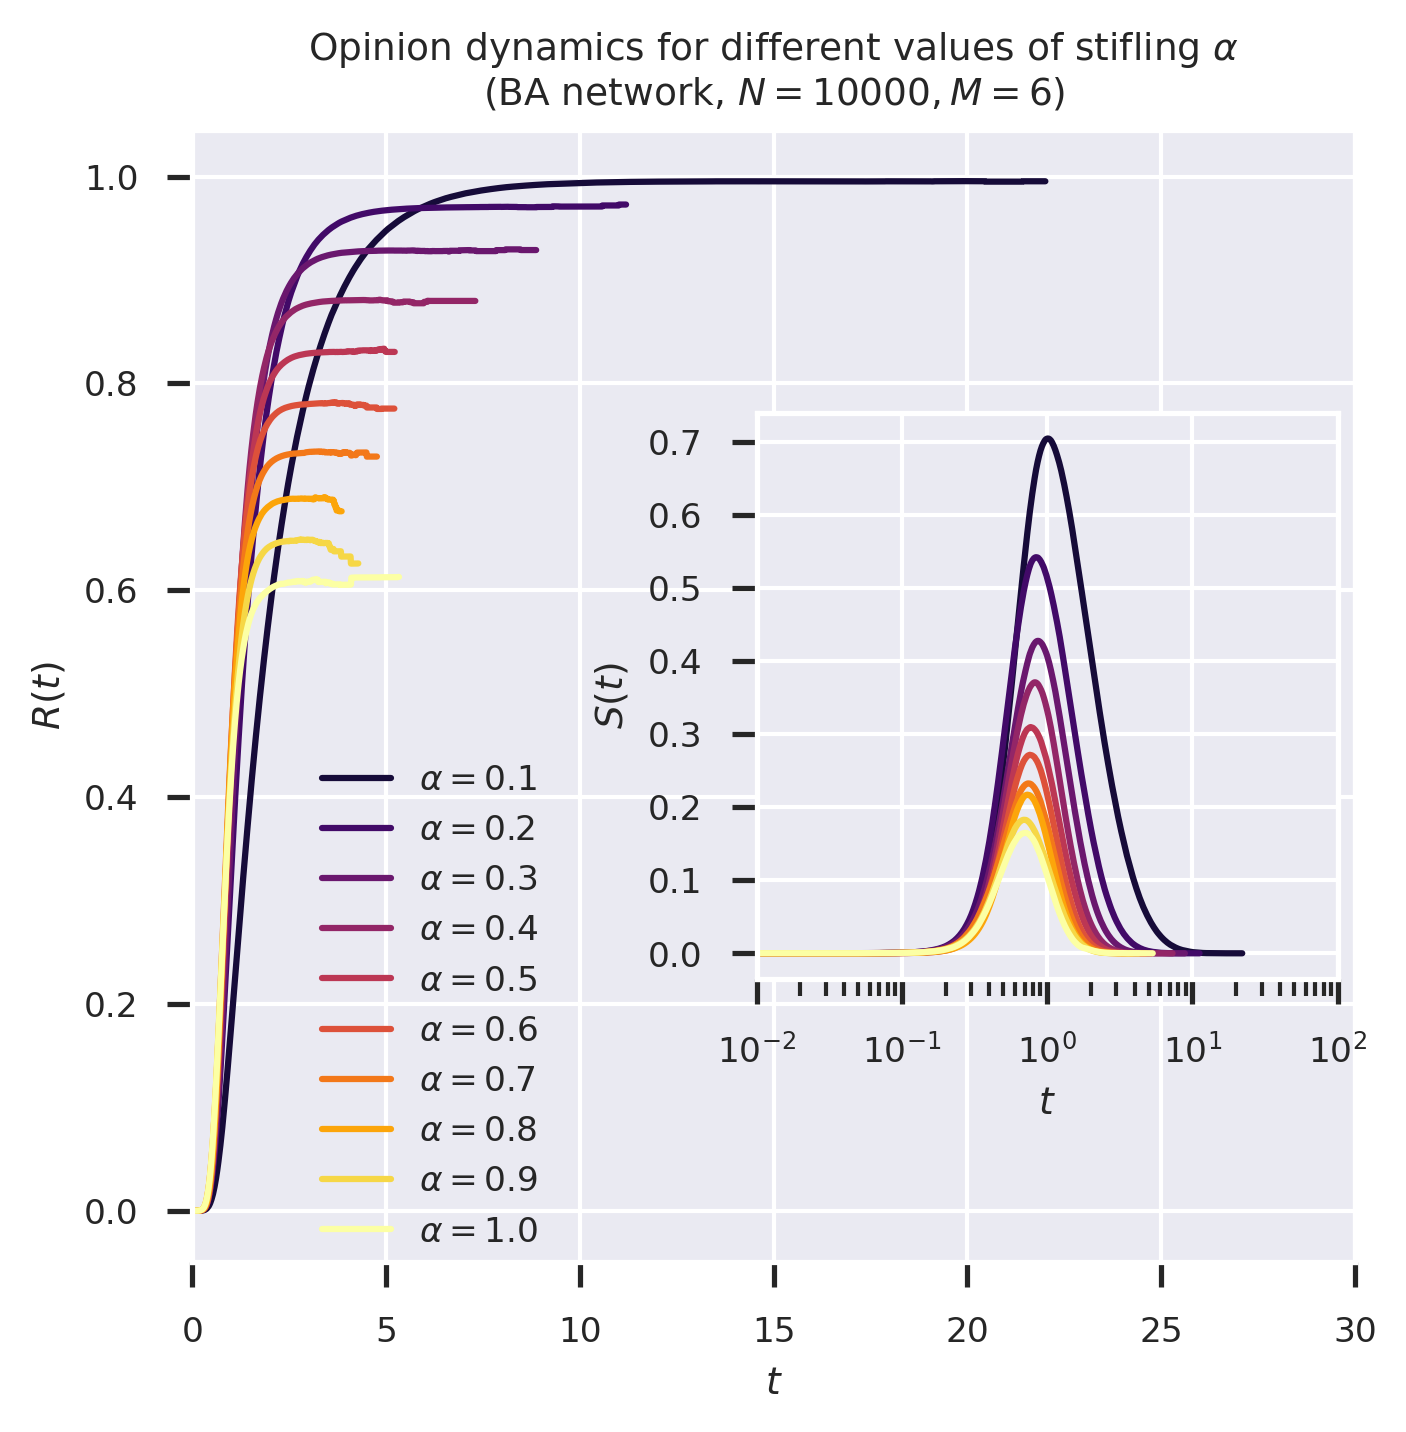

In [8]:
fig, ax = plt.subplots(figsize=(5,5))
ax2 = inset_axes(ax, width="50%", height="50%", loc="center right")

nb.select('stifler-ba')
df = lab.dataframe()

colourMap = get_cmap('inferno')

pStifles = sorted(df[Opinion.P_STIFLE].unique())
for pStifle in pStifles:
    dfs = df[df[Opinion.P_STIFLE] == pStifle]
    N = dfs[BANetwork.N].mean()
    ts = dfs.loc[(dfs[Monitor.OBSERVATIONS].apply(len) == dfs[Monitor.OBSERVATIONS].apply(len).max())].iloc[0][Monitor.OBSERVATIONS]

    col = colourMap(pStifle)

    # main plot: fraction of stiflers against time
    stiflers = DataFrame(dfs[Monitor.timeSeriesForLocus(Opinion.STIFLER)].values.tolist()).rename(columns=lambda i: ts[i])
    stiflersmean = stiflers.mean()
    ax.plot(ts[:len(stiflersmean)], [R / N for R in stiflersmean], color=col, label=f'$\\alpha = {pStifle:.1f}$')
    
    # inset: fraction of spreaders against log(time)
    spreaders = DataFrame(dfs[Monitor.timeSeriesForLocus(Opinion.SPREADER)].values.tolist()).rename(columns=lambda i: ts[i])
    spreadersmean = spreaders.mean()
    ax2.plot(ts[:len(spreadersmean)], [S / N for S in spreadersmean], color=col)

ax.set_ylabel('$R(t)$')
ax.set_xlabel('$t$')
ax.set_xlim([0, 30])
ax.legend(loc=[0.1, 0.0])
ax.set_title('Opinion dynamics for different values of stifling $\\alpha$\n(BA network, $N = {N}, M = {M}$)'.format(N=int(1e4), M=6))

ax2.set_ylabel('$S(t)$')
ax2.set_xlabel('$t$')
ax2.set_xscale('log')
ax2.set_xlim([1e-2, 1e2])

_ = plt.show()

In [9]:
class IgnorantsDistribution(SingleSpreader):
    
    IGNORANTS_DIST = 'ignorants_dist'
    
    def results(self):
        rc = super().results()
        
        # extract the degree histogram of only the ignorant nodes
        g = self.network().copy()
        N = g.order()
        nonignorants = [n for n in g.nodes if self.getCompartment(n) != self.IGNORANT]
        g.remove_nodes_from(nonignorants)
        ni = g.order()
        hist = degree_histogram(g)
        for k in range(len(hist)):
            hist[k] /= ni
                
        rc[self.IGNORANTS_DIST] = hist
        return rc        

In [10]:
def create_ignorants_ba():
    lab.deleteAllParameters()

    lab[BANetwork.N] = int(1e4)
    lab[BANetwork.M] = 6
    lab[Opinion.P_AFFECTED] = 0.01
    lab[Opinion.P_AFFECT] = 1
    lab[Opinion.P_STIFLE] = [0.1, 0.2, 0.5, 1.0]
    lab['rep'] = range(100)
    
    e = StochasticDynamics(IgnorantsDistribution(), BANetwork())
    lab.runExperiment(e)

In [11]:
nb.createWith('final-ignorants-distribution-ba', create_ignorants_ba, description="Final density of ignorants, BA network")

True

In [12]:
df = nb.dataframe()
print((df[Experiment.END_TIME].max() - df[Experiment.START_TIME].min()).seconds)

453


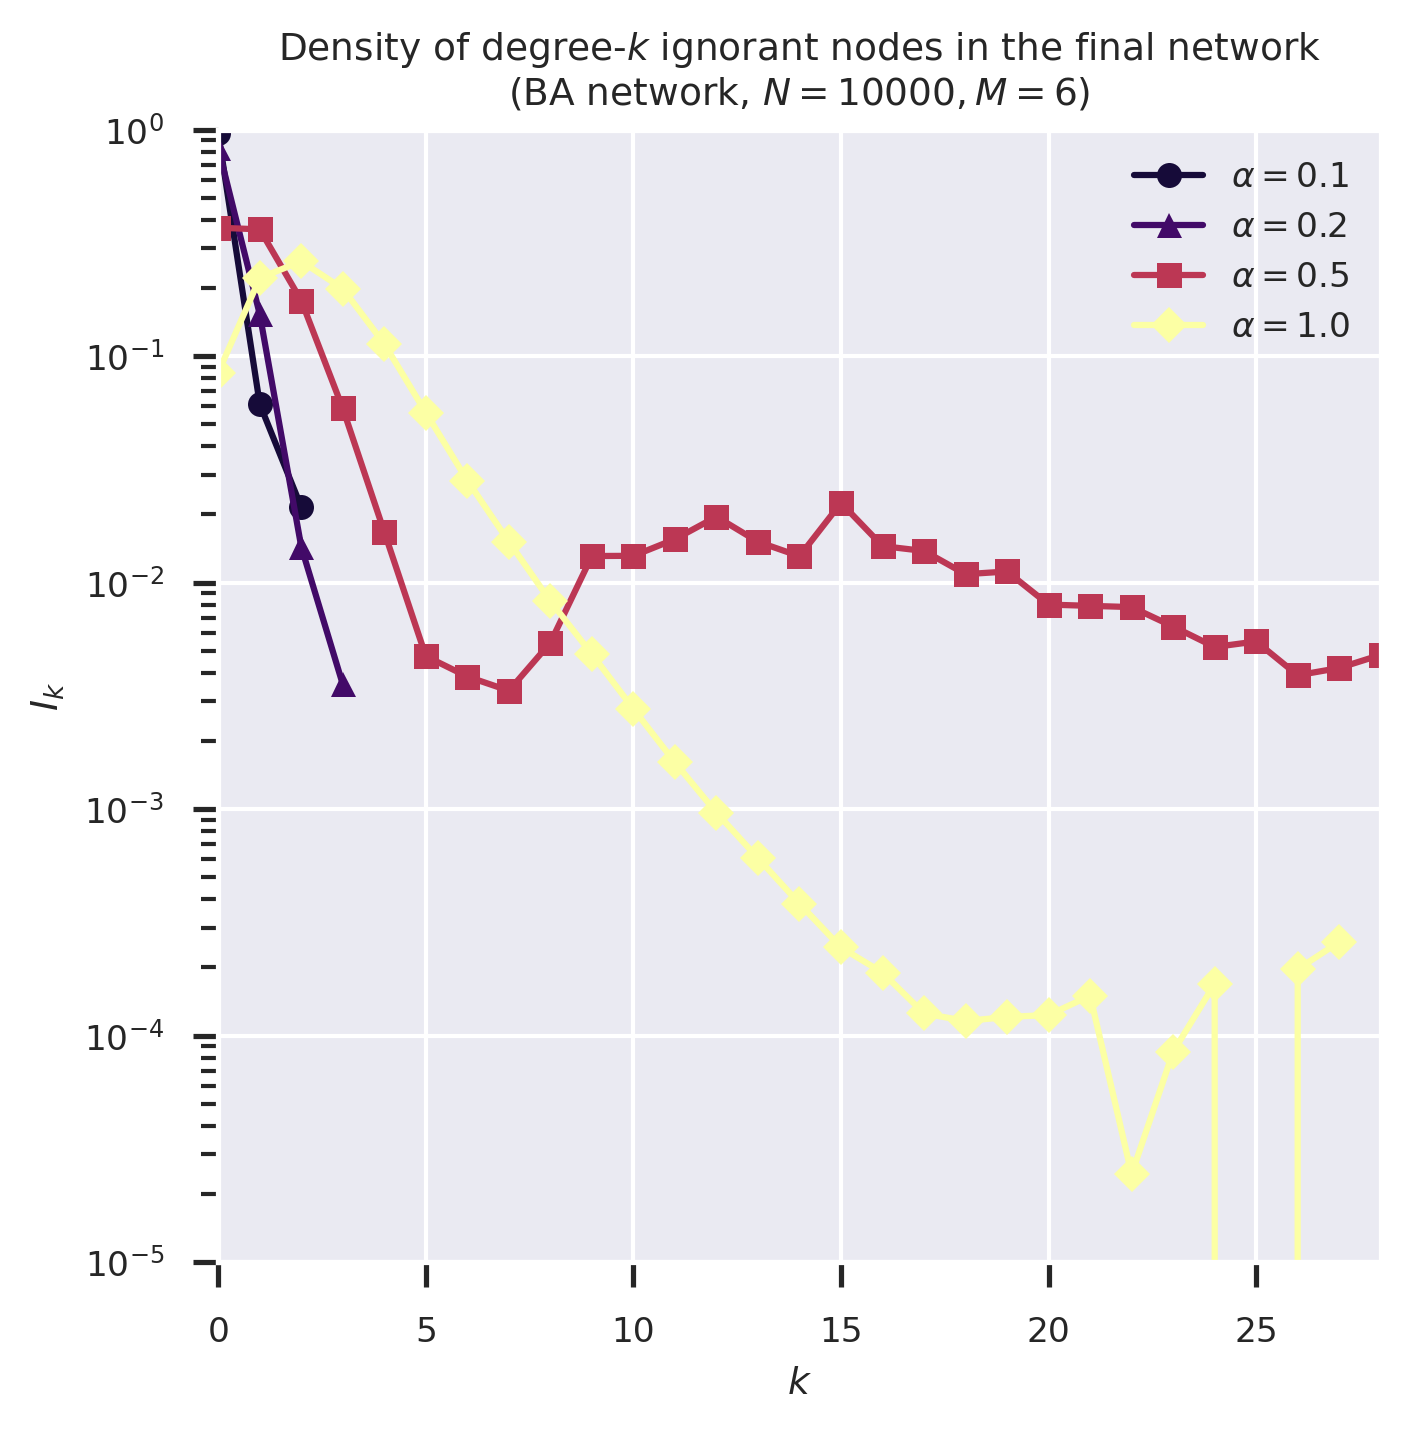

In [13]:
fig, ax = plt.subplots(figsize=(5,5))

nb.select('final-ignorants-distribution-ba')
df = lab.dataframe()

colourMap = get_cmap('inferno')
markers = ['o', '^', 's', 'D']
           
pStifles = sorted(df[Opinion.P_STIFLE].unique())
for i in range(len(pStifles)):
    pStifle = pStifles[i]
    dfs = df[df[Opinion.P_STIFLE] == pStifle]
    N = dfs[BANetwork.N].mean()
    kmax = dfs[IgnorantsDistribution.IGNORANTS_DIST].apply(len).max()
    
    col = colourMap(pStifle)
    mark = markers[i]

    ignorants = DataFrame(dfs[IgnorantsDistribution.IGNORANTS_DIST].values.tolist()).rename(columns=lambda i: i)
    ignorantsmean = ignorants.mean()

    kmin = 0
    for k in range(kmax):
        if ignorantsmean[k] > 0:
            break
        kmin += 1
    ks = range(kmin, kmax)
    ax.plot(ks, ignorantsmean[kmin:kmax],
            color=col, marker = mark,
            label=f'$\\alpha = {pStifle:.1f}$')
    
ax.set_ylabel('$I_k$')
ax.set_ylim([1e-5, 1])
ax.set_yscale('log')
ax.set_xlabel('$k$')
ax.set_xlim([0, kmax])
ax.legend(loc='upper right')
ax.set_title('Density of degree-$k$ ignorant nodes in the final network\n(BA network, $N = {N}, M = {M}$)'.format(N=int(1e4), M=6))

_ = plt.show()